# Loveida Lucero

# ARIMA Models (Core)
- Load this [Walmart stock data](https://drive.google.com/file/d/1KKR8TZbkixVN2NundM2mEVv5AhjHhs9a/view?usp=sharing)​.    ([source](https://www.kaggle.com/datasets/meetnagadia/walmart-stock-price-from-19722022)​​)
- We will use data from 2010 to 2020 to predict the  Adjusted Close values for the next quarter.
- Make a datetime index using the Date column with a business day frequency ('B')
- Check for and address null values.
- Check the time series for stationarity.
  - Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)
- Use ACF/PACF plots of the stationary data to estimate initial time series model orders​ (p,d,q)
- Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)
- Fit an ARIMA model based on the orders determined during your exploration.
  - Make forecasts with your model.
  - Plot the forecasts versus the test data.
  - Obtain metrics for evaluation.
- Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)
- A MAPE of less than 2% on the test data is achievable.
- Choose a final model and explain:
  - How good was your model, according to your Mean Absolute Percentage Error?
  - How good was your model in terms of how well the forecast seems to follow the test data, visually?  (Hint: You may want to plot fewer training data lags to see this)

**Imports**

In [1]:
# Commented out to avoid reinstalling 
#!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs
import itertools

**Custom Functions**

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [5]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

**Load Data**

In [7]:
df = pd.read_csv('Data/WMT.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5479 non-null   object 
 1   Adj Close  5284 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.7+ KB


,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


## Make a datetime index using the Date column with a business day frequency ('B')

In [8]:
# Make Date a datetime object 
df['Date'] = pd.to_datetime(df['Date'])
# Make Date the index
df = df.set_index('Date')
# We have weekly data so we will set our frequency to W
df.index.freq= "B"

## Check for and address null values.

In [9]:
# display null counts
df.isna().sum()

Adj Close    195
dtype: int64

In [10]:
# forward fill nulls
df = df.ffill()

# confirm dropped nulls
df.isna().sum()

Adj Close    0
dtype: int64

## Check the time series for stationarity.
- Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)

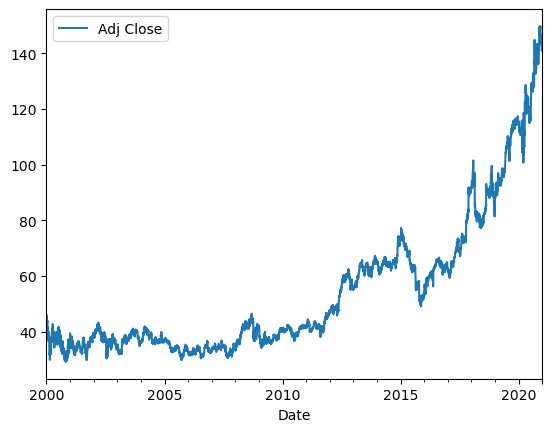

In [11]:
df.plot();

In [12]:
# tsa.adfuller(df)
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,2.45764,32,5446,0.999035,0.05,False


In [13]:
# obtaing diff number
ndiffs(df)

2

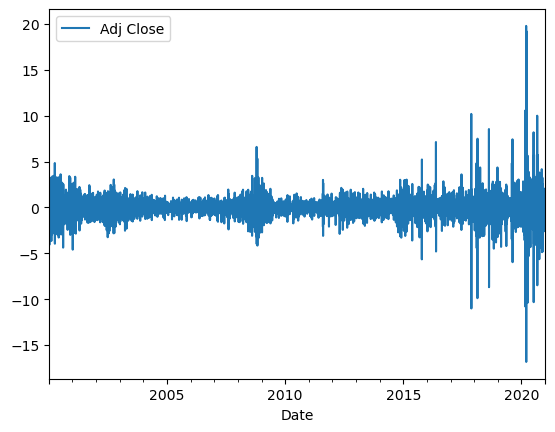

In [14]:
# define new df with 2 diffs
df_diff2 = df.diff().diff()
df_diff2 = df_diff2.dropna()

#plot new df
df_diff2.plot();

In [15]:
# is it stationary?
get_adfuller_results(df_diff2)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-22.31972,33,5443,0.0,0.05,True


## Use ACF/PACF plots of the stationary data to estimate initial time series model orders​ (p,d,q)

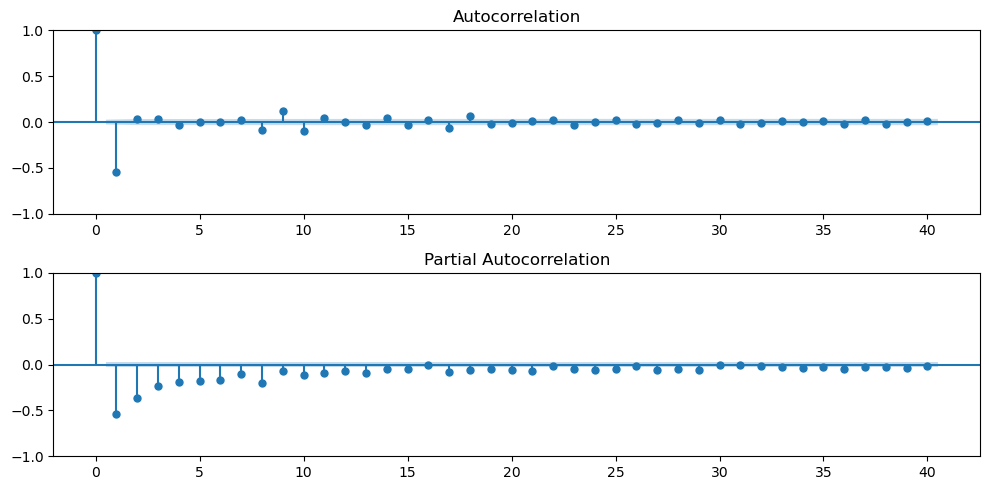

In [16]:
plot_acf_pacf(df_diff2);

## Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)

In [17]:
13*5

65

In [18]:
# train test split
train, test = train_test_split(df, test_size = 65)

train.shape, test.shape

((5414, 1), (65, 1))

## Fit an ARIMA model based on the orders determined during your exploration.
- Make forecasts with your model.
- Plot the forecasts versus the test data.
- Obtain metrics for evaluation.

*Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)*

In [19]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [2]          
q_values = range(0, 3)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [20]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 17599.851772173064
(0, 2, 1) 13369.86282710109
(0, 2, 2) 13319.347173854982
(1, 2, 0) 15737.030328265622
(1, 2, 1) 13321.060555352105
(1, 2, 2) 13373.862431869911
(2, 2, 0) 14997.342386606297
(2, 2, 1) 13320.89614820381
(2, 2, 2) 13324.379845415708
Best AIC: 13319.347173854982
Best pdq: (0, 2, 2)


### Best Model

In [21]:
# Define pdq
p = 0
d = 2
q = 2

# fit best pdq to model
model = tsa.ARIMA(df, order=(p, d, q)).fit()

# display model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5479
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -6790.321
Date:                Tue, 28 Nov 2023   AIC                          13586.642
Time:                        23:12:07   BIC                          13606.466
Sample:                    01-03-2000   HQIC                         13593.558
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1030      0.004   -249.856      0.000      -1.112      -1.094
ma.L2          0.1037      0.004     23.774      0.000       0.095       0.112
sigma2         0.6980      0.003    203.320      0.000       0.691       0.705
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            213133.48
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

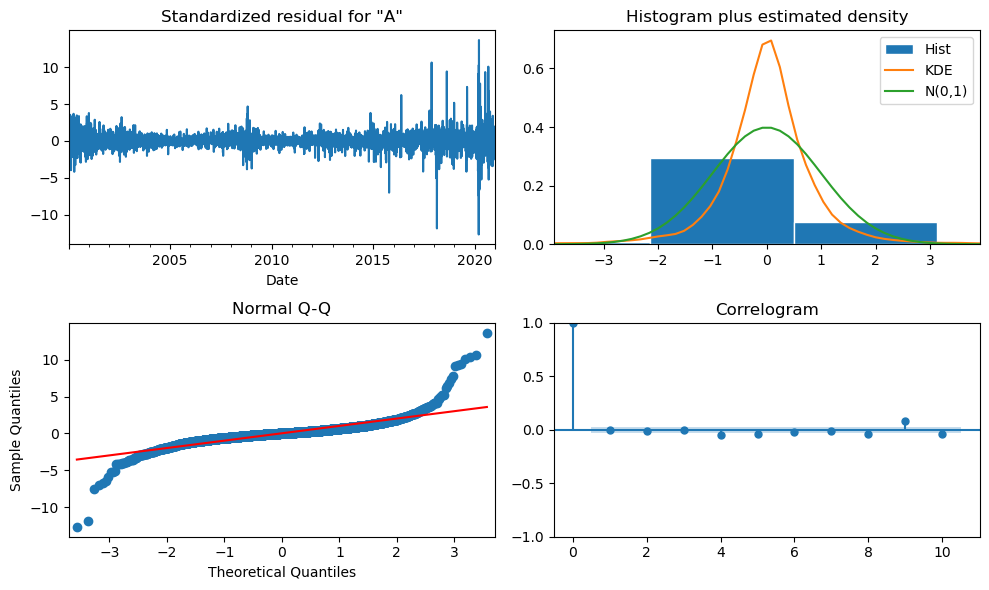

In [22]:
# Obtain diagnostic plots
fig = model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

### Alternate model

In [23]:
# Define pdq
p = 0
d = 2
q = 0

# fit best pdq to model
model2 = tsa.ARIMA(df, order=(p, d, q)).fit()

# display model summary
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5479
Model:                 ARIMA(0, 2, 0)   Log Likelihood               -8972.492
Date:                Tue, 28 Nov 2023   AIC                          17946.985
Time:                        23:12:08   BIC                          17953.593
Sample:                    01-03-2000   HQIC                         17949.290
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5504      0.007    238.149      0.000       1.538       1.563
===================================================================================
Ljung-Box (L1) (Q):                1599.82   Jarque-Bera (JB):            354993.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.70   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

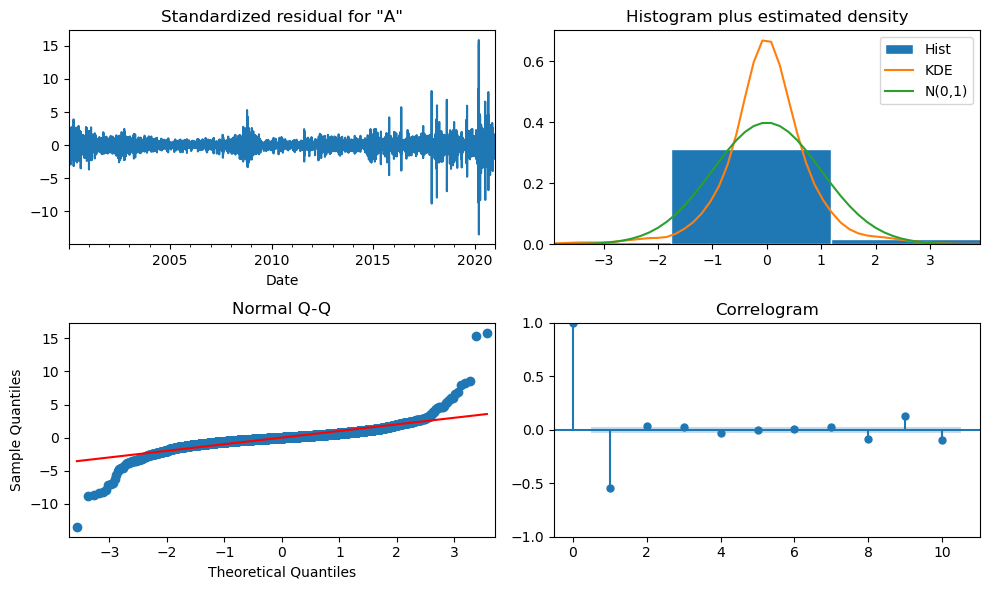

In [24]:
# Obtain diagnostic plots
fig = model2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## Choose a final model and explain:
- How good was your model, according to your Mean Absolute Percentage Error?
- How good was your model in terms of how well the forecast seems to follow the test data, visually? (Hint: You may want to plot fewer training data lags to see this)

In [31]:
# Obtain summary of forecast as dataframe
forecast_df = model.get_forecast(len(test)).summary_frame()
forecast_df2 = model2.get_forecast(len(test)).summary_frame()

best = regression_metrics_ts(test, forecast_df['mean'])
print(f'Model (0,2,2) \n{best}')

alternate = regression_metrics_ts(test, forecast_df2['mean'])
print(f'Model (0,2,0) \n{alternate}')

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.831
- MSE = 10.864
- RMSE = 3.296
- R^2 = 0.155
- MAPE = 1.98%
Model (0,2,2) 
None
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.617
- MSE = 19.779
- RMSE = 4.447
- R^2 = -0.538
- MAPE = 2.50%
Model (0,2,0) 
None


- The ARIMA (0,2,2) performs better in each metric including Mean Absolute Percentage Error(MAPE). 

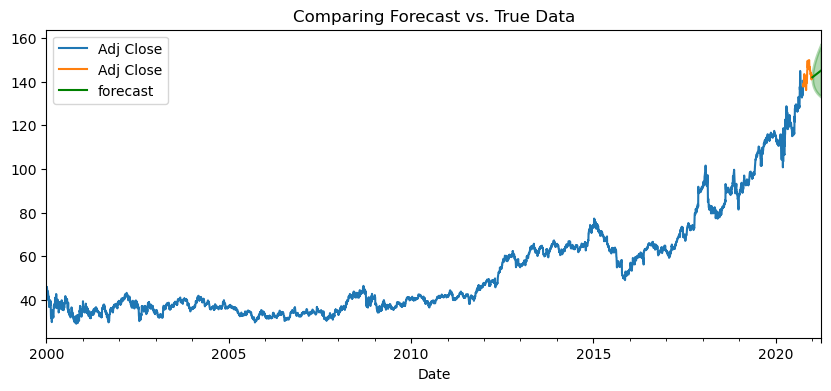

In [26]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df);